# Проект: классификация

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [28]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [29]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


### Задание 2

In [30]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df.job.value_counts()


management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [31]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
print(df.balance[0])
print(df.balance[0].replace(' ', '').strip('$ ').replace(",", "."))
float(df.balance[0].replace(' ', '').strip('$ ').replace(",", "."))

 2 343,00 $ 
2343.00


2343.0

In [32]:
type(df.balance[0])
df.balance[0]
df.balance[0].strip().strip('$').strip()

'2 343,00'

In [33]:
type(df.balance[0])

str

In [34]:
for i in range(0,len(df['balance'])):
    if type(df.balance[i]) is str:
        df.balance[i] = float(df.balance[i].replace(' ', '').strip('$').replace(",", "."))

In [35]:
df.balance.mean()

1529.1290293615875

### Задание 4

In [36]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
med = df.balance.median()
df.balance = df.balance.fillna(med)

In [37]:
df.balance.info()

<class 'pandas.core.series.Series'>
RangeIndex: 11162 entries, 0 to 11161
Series name: balance
Non-Null Count  Dtype  
--------------  -----  
11162 non-null  float64
dtypes: float64(1)
memory usage: 87.3 KB


In [38]:
df.balance.describe()

count    11162.000000
mean      1526.936033
std       3224.829691
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1699.000000
max      81204.000000
Name: balance, dtype: float64

### Задание 5

In [39]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
job_mode = df.job.mode()
df.job[df.job=='unknown'] = 'management'

edu_mode = df.education.mode()
df.education[df.education=='unknown'] = 'secondary'

In [40]:
# df.education.mode()

In [41]:
# df.job.mode()

In [42]:
round(df[(df['job']=='management') & (df['education']=='secondary')]['balance'].mean(),3)

1598.883

### Задание 6

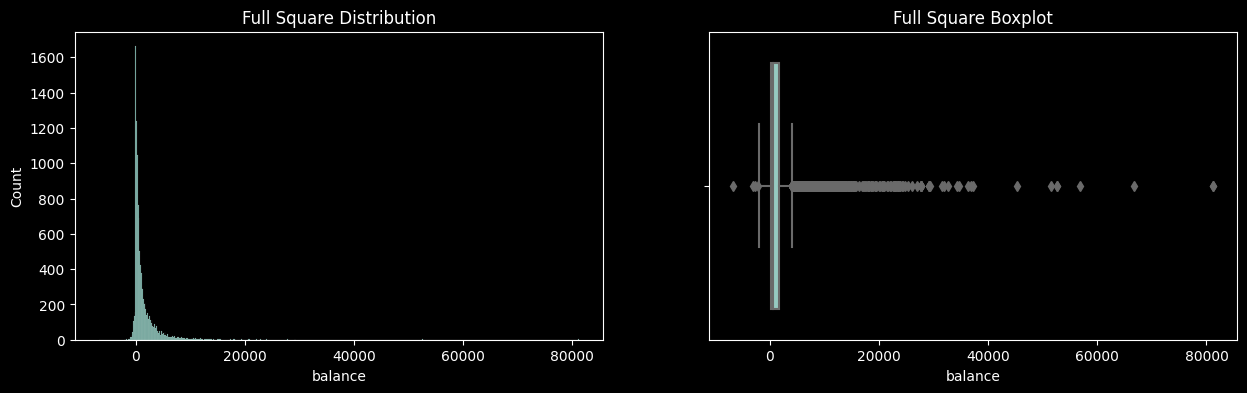

In [43]:
# удалите все выбросы для признака balance
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='balance', ax=axes[0]);
histplot.set_title('Full Square Distribution');
boxplot = sns.boxplot(data=df, x='balance', ax=axes[1]);
boxplot.set_title('Full Square Boxplot');

In [44]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    print(lower_bound,upper_bound)
    return outliers, cleaned

In [45]:
outliers, cleaned = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

-2241.0 4063.0
Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


In [46]:
df = cleaned

## Часть 2:  Разведывательный анализ

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  object 
 4   default    10105 non-null  object 
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  object 
 7   loan       10105 non-null  object 
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


### Задание 1

In [48]:
df[df.deposit=='yes'].count()[0]

4681

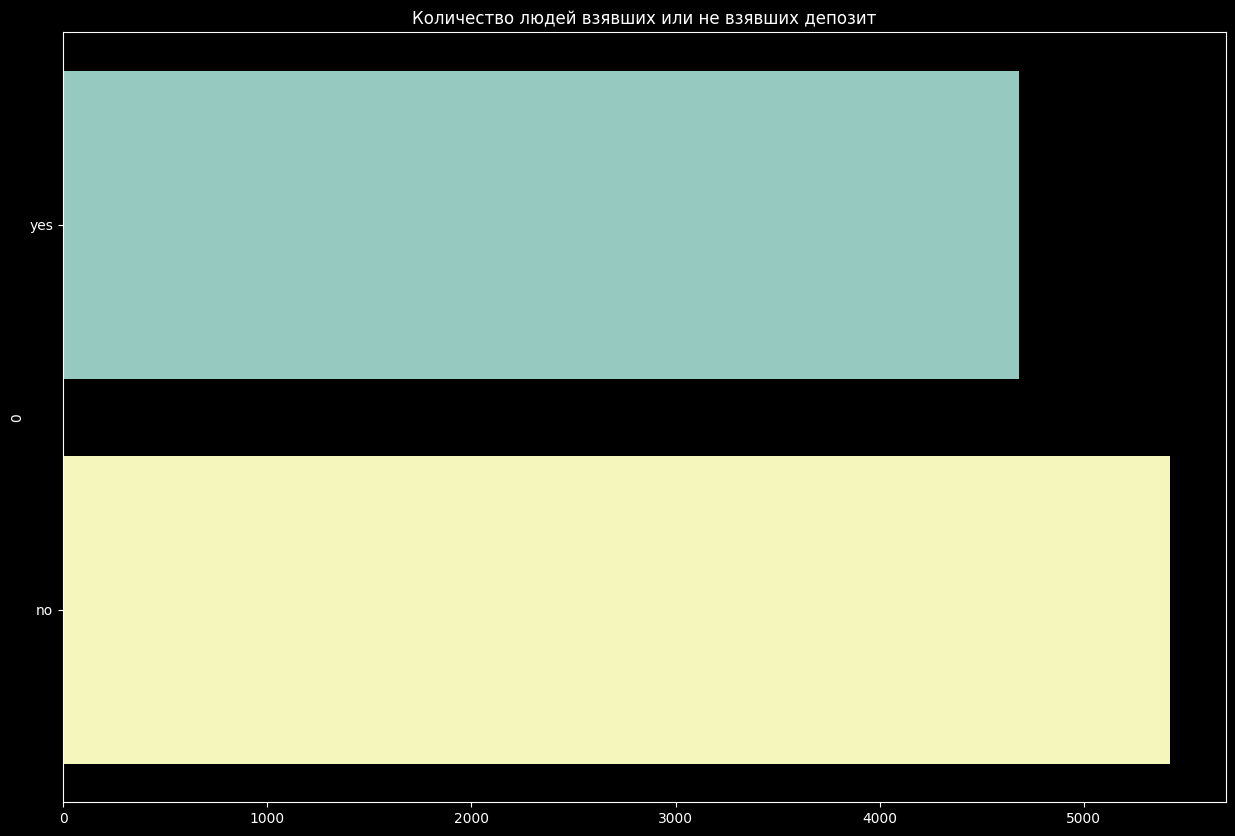

In [49]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат

bpdf = pd.DataFrame(
    ['yes','no'],
    [df[df.deposit=='yes'].count()[0],df[df.deposit=='no'].count()[0]]
)


fig = plt.figure(figsize=(15, 10))
barplot = sns.barplot(
    data=df,
    x=bpdf.index,
    y=bpdf[0]
)

barplot.set_title('Количество людей взявших или не взявших депозит');

In [50]:
df[(df.deposit=='yes')].count()[0]

4681

### Задания 2 и 3

<AxesSubplot:>

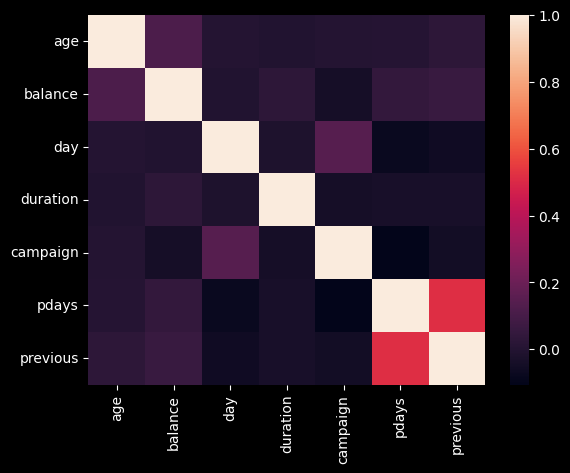

In [51]:
corr = df.select_dtypes('number').corr()

# plot the heatmap

sns.heatmap(corr)

In [53]:
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

minmax = df.apply(minMax)
display(minmax)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
min,18,admin.,divorced,primary,no,-2049.0,no,no,cellular,1,apr,2,1,-1,0,failure,no
max,95,unemployed,single,tertiary,yes,4063.0,yes,yes,unknown,31,sep,3881,43,854,58,unknown,yes


In [54]:
minmax = pd.DataFrame(minmax)
display(minmax)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
min,18,admin.,divorced,primary,no,-2049.0,no,no,cellular,1,apr,2,1,-1,0,failure,no
max,95,unemployed,single,tertiary,yes,4063.0,yes,yes,unknown,31,sep,3881,43,854,58,unknown,yes


In [55]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код

### Задания 4 и 5

In [56]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты

In [57]:
df.month.value_counts().count()

12

In [58]:
df.job.value_counts().count()

11

### Задание 6

In [59]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код

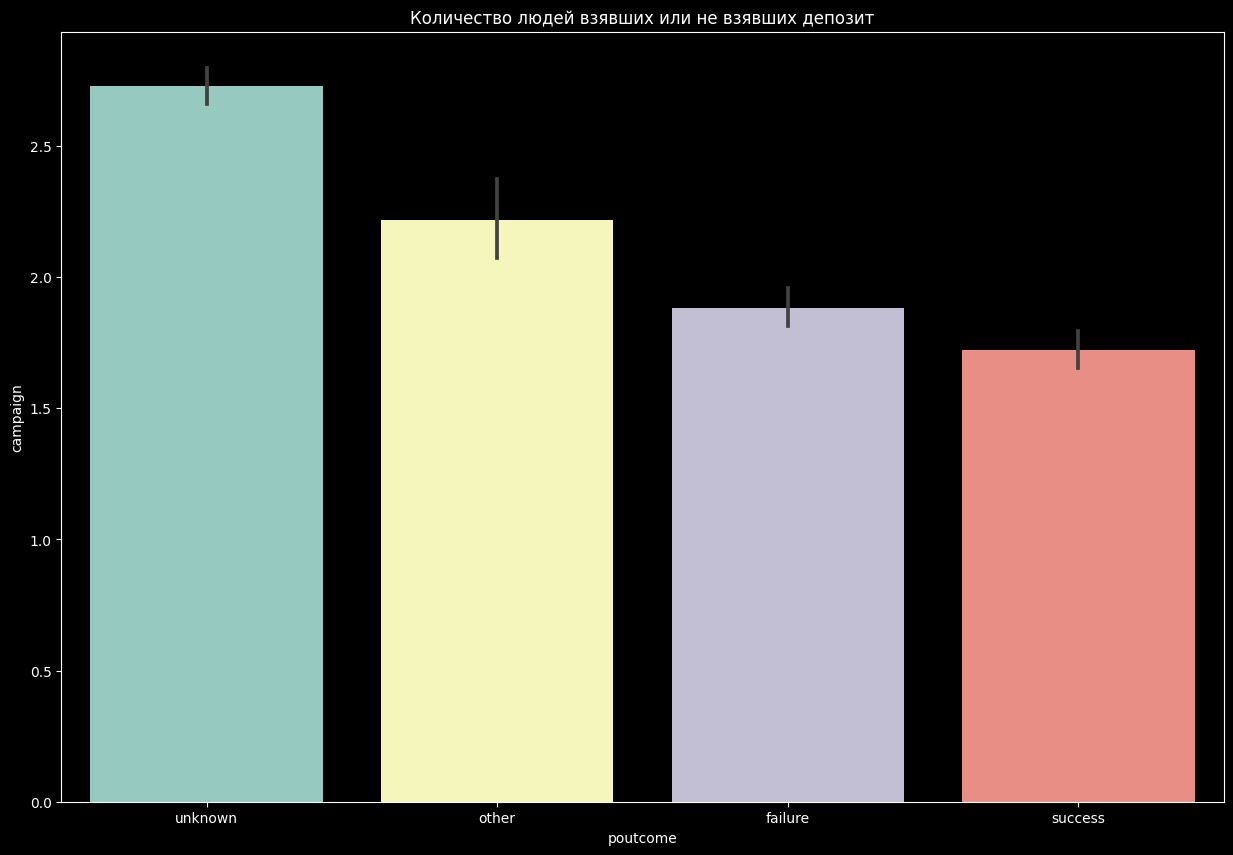

In [60]:
bpdf = pd.DataFrame(
    ['yes','no'],
    [df[df.deposit=='yes'].count()[0],df[df.deposit=='no'].count()[0]]
)


fig = plt.figure(figsize=(15, 10))
barplot = sns.barplot(
    data=df,
    x='poutcome',
    y='campaign'
)

barplot.set_title('Количество людей взявших или не взявших депозит');

### Задание 7

In [61]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код

In [62]:
bpdf = df[['month', 'deposit']]
bpdf['deposit'] = bpdf['deposit'].apply(lambda x: 0 if x == 'no' else 1)
display(bpdf.groupby(["month"])["deposit"].sum()/bpdf.groupby(["month"])["deposit"].count())

month
apr    0.618072
aug    0.440433
dec    0.903226
feb    0.544429
jan    0.391850
jul    0.410437
jun    0.451087
mar    0.898734
may    0.321360
nov    0.415385
oct    0.814925
sep    0.834532
Name: deposit, dtype: float64

In [63]:
# for month in bpdf['month']:
#     print(month)
#     print(bpdf[bpdf['month'==month]].len())
#     print(bpdf[bpdf['month'==month]['poutcome']].sum())

,month,deposit
0,may,1
1,may,1
2,may,1
3,may,1
4,may,1
...,...,...
11157,apr,0
11158,jun,0
11159,aug,0
11160,may,0


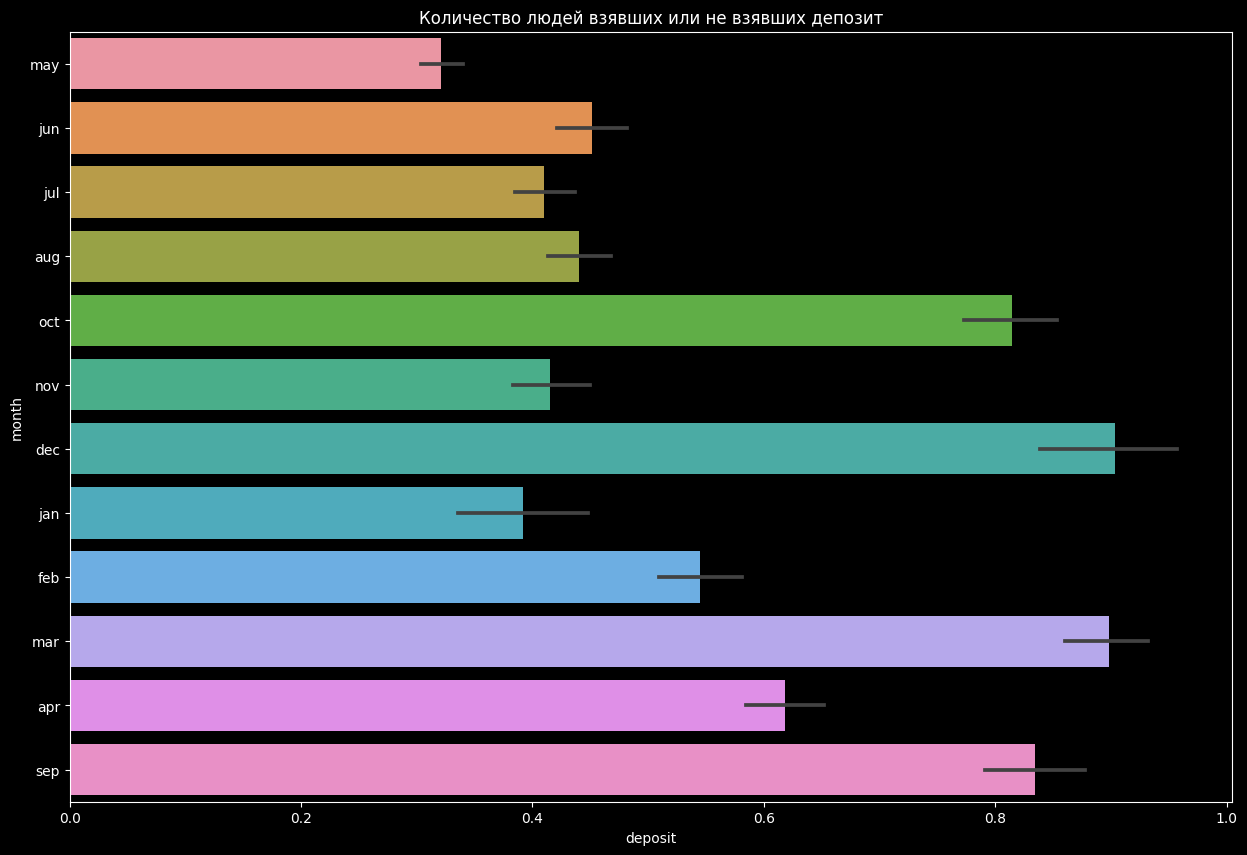

In [64]:
bpdf = df[['month', 'deposit']]
bpdf['deposit'] = bpdf['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
display(bpdf)

# for i in bpdf(month):
#     print(month, (bpdf[bpdf['month'==month]['poutcome']]/bpdf[month].len()))

fig = plt.figure(figsize=(15, 10))
barplot = sns.barplot(
    data=bpdf,
    x='deposit',
    y='month'
)

barplot.set_title('Количество людей взявших или не взявших депозит');



### Задание 8

In [65]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def age_grouper(age):
    if age < 30:
        return 0
    if 30 <= age < 40:
        return 1
    if 40 <= age < 50:
        return 2
    if 50 <= age < 60:
        return 3
    else:
        return 4

df['age_group'] = df['age'].apply(age_grouper)
display(df)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,3
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,3
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,2
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,3
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no,1
11158,39,services,married,secondary,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no,1
11159,32,technician,single,secondary,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no,1
11160,43,technician,married,secondary,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no,2


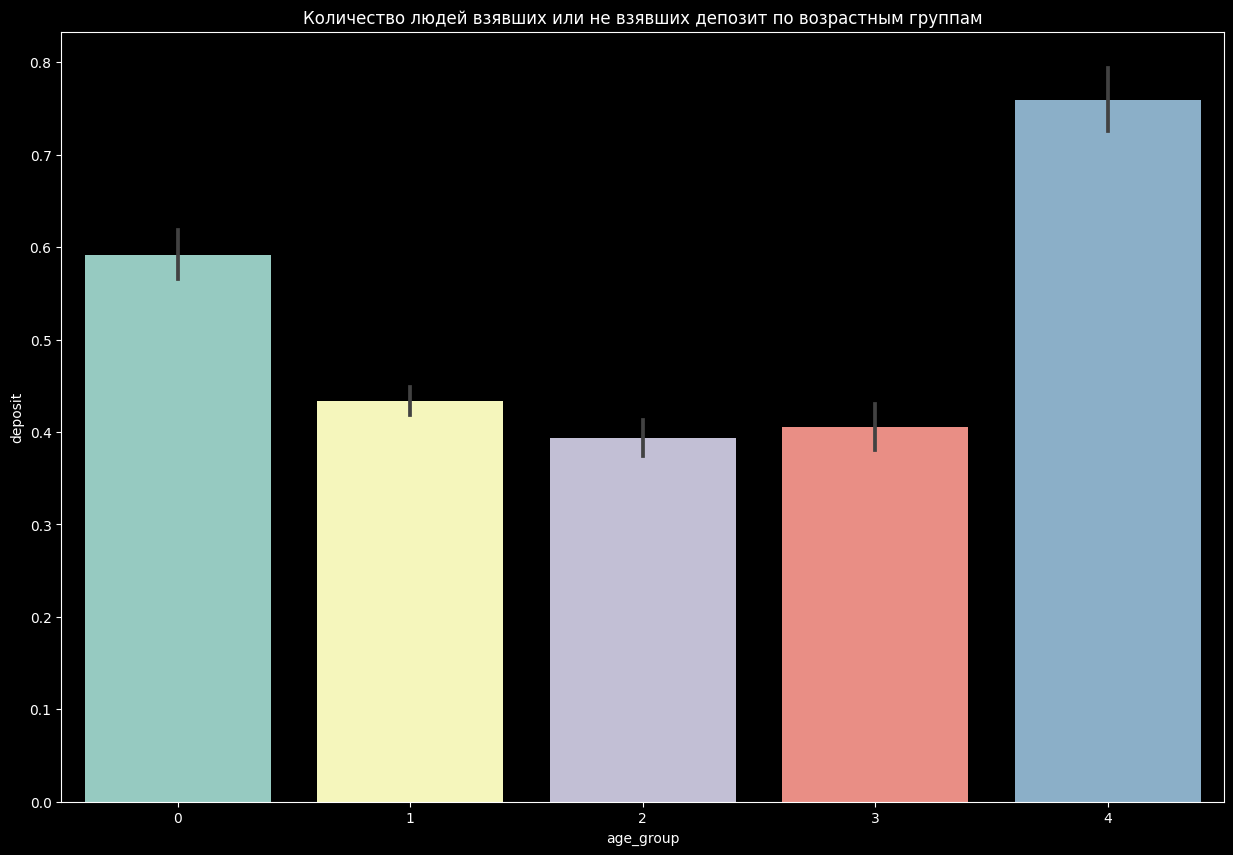

In [66]:
dfp = df[['age_group', 'deposit']]

dfp['deposit'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

fig = plt.figure(figsize=(15, 10))
barplot = sns.barplot(
    data=dfp,
    x='age_group',
    y='deposit'
)

barplot.set_title('Количество людей взявших или не взявших депозит по возрастным группам');

### Задания 9 и 10

In [67]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса


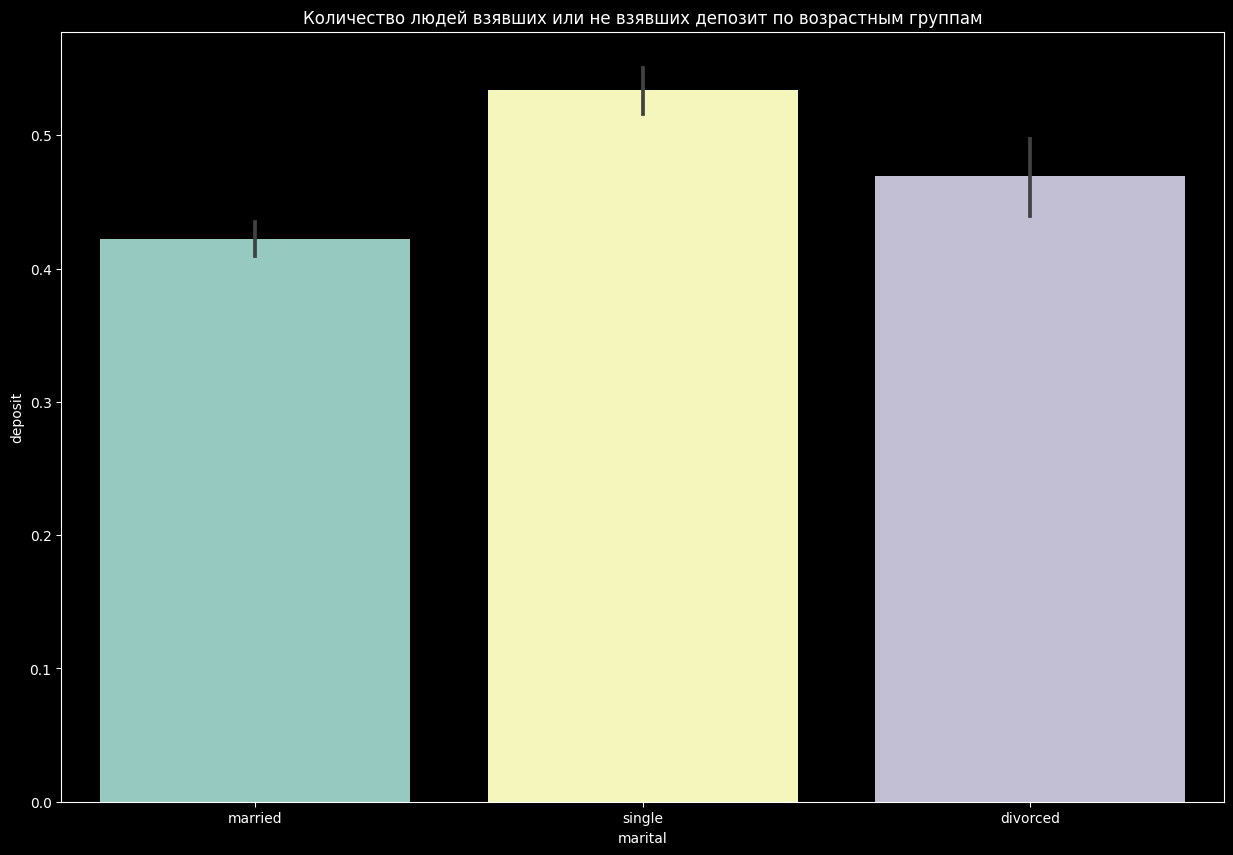

In [68]:
dfp['marital'] = df['marital']
fig = plt.figure(figsize=(15, 10))
barplot = sns.barplot(
    data=dfp,
    x='marital',
    y='deposit'
)

barplot.set_title('Количество людей взявших или не взявших депозит по возрастным группам');

0    management
Name: job, dtype: object

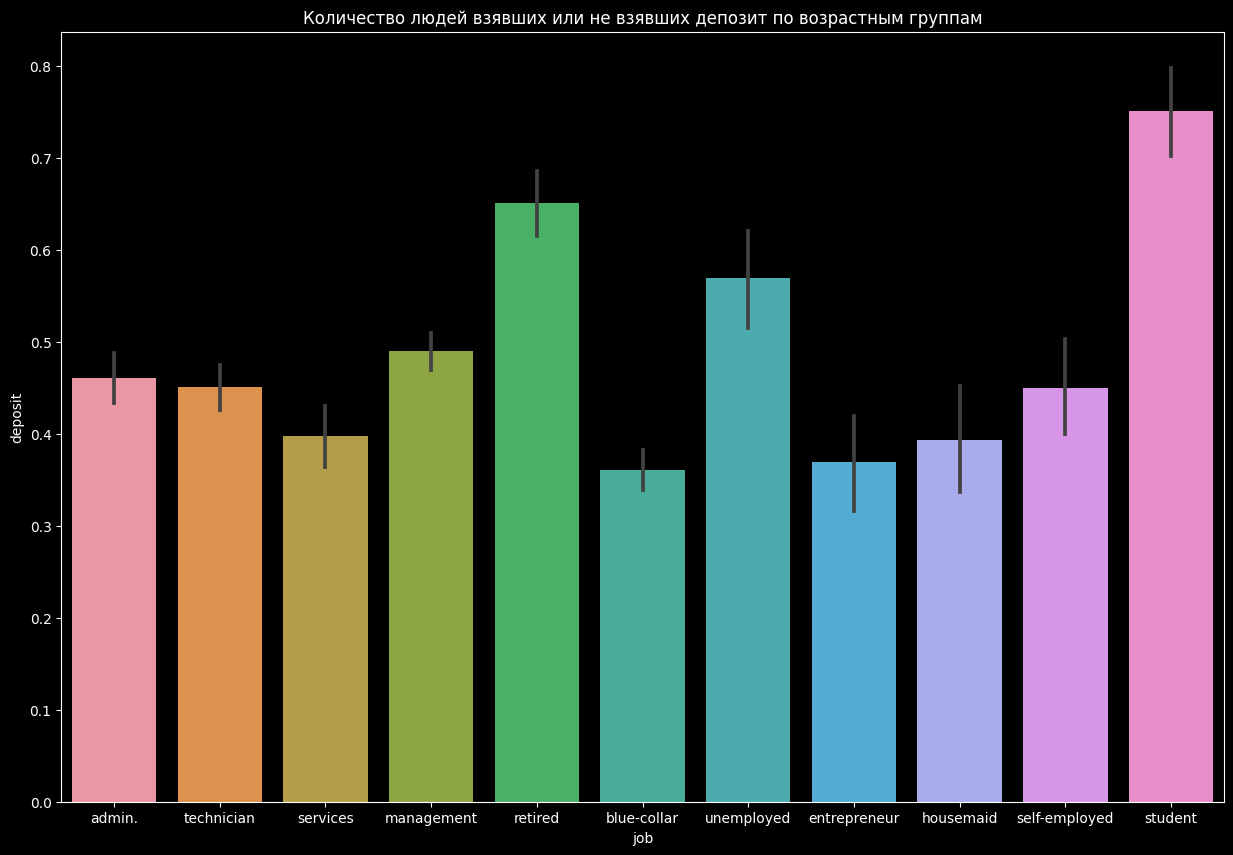

In [69]:
dfp['job'] = df['job']
fig = plt.figure(figsize=(15, 10))
barplot = sns.barplot(
    data=dfp,
    x='job',
    y='deposit'
)

barplot.set_title('Количество людей взявших или не взявших депозит по возрастным группам');
display(dfp['job'].mode())

In [70]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

In [71]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

### Задание 11

In [72]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

In [73]:
dfp['education'] = df['education']

In [74]:
dfp0 = dfp[dfp['deposit']==0]
dfp1 = dfp[dfp['deposit']==1]

Text(0, 0.5, 'Пол соискателя')

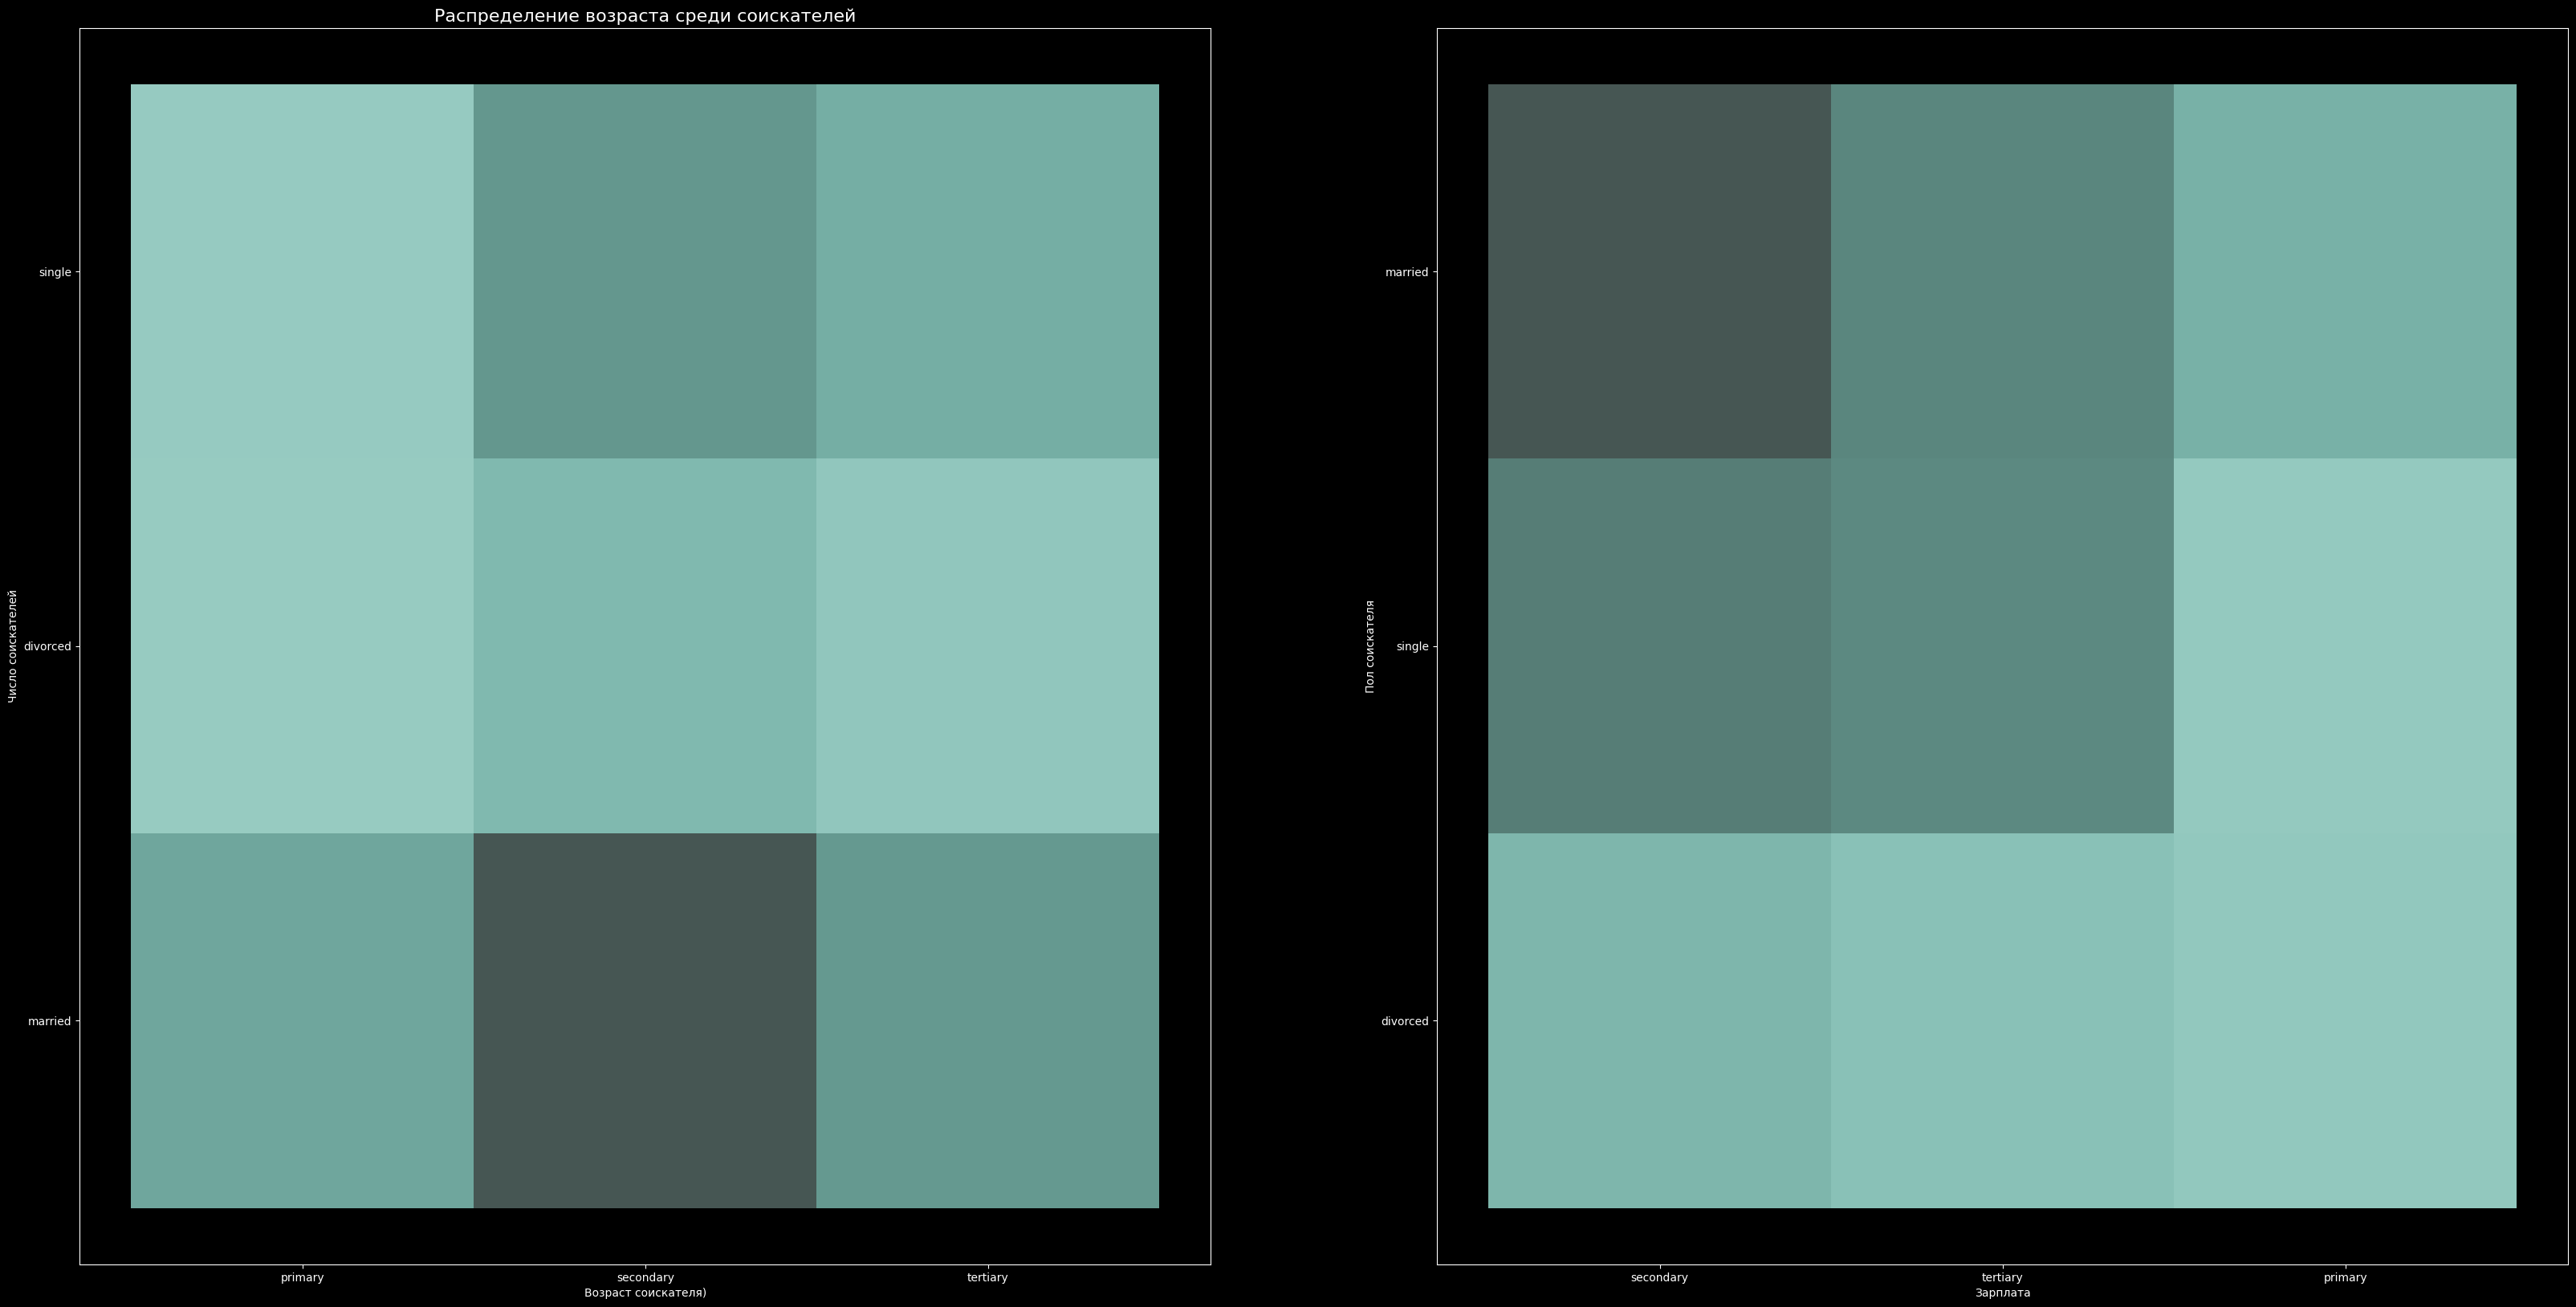

In [75]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(40, 20))
plt.subplots_adjust(hspace=.0)

histplot1 = sns.histplot(
    data=dfp0, 
    x='education',
    y='marital',
    bins=200,
    ax=axes[0],
)
histplot1.set_title('Распределение возраста среди соискателей',\
                    fontsize=16)
histplot1.set_xlabel('Возраст соискателя)')
histplot1.set_ylabel('Число соискателей')

histplot2 = sns.histplot(
    data=dfp1,
    x='education',
    y='marital',
    bins=200,
    ax=axes[1]
)
histplot2.set_xlabel('Зарплата')
histplot2.set_ylabel('Пол соискателя')

## Часть 3: преобразование данных

### Задание 1

In [76]:
# преобразуйте уровни образования
le = preprocessing.LabelEncoder()

le.fit(df['education'])

df['education'] = le.transform(df['education'])


In [77]:
df['age_group'] = le.fit_transform(df['age_group'])

In [78]:
df['deposit'] = dfp['deposit']

In [79]:
round(np.std(df['deposit']),3)

0.499

### Задания 2 и 3

In [80]:
# преобразуйте бинарные переменные в представление из нулей и единиц

In [81]:
def binary(x):
    if x == 'yes':
        return 1
    else: return 0

In [82]:
df['default'] = df['default'].apply(binary)
df['housing'] = df['housing'].apply(binary)
df['loan'] = df['loan'].apply(binary)

In [83]:
df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,3
1,56,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,3
2,41,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,2
3,55,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1,3
4,54,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1,3


In [84]:
df['default'].mean()+df['housing'].mean()+df['loan'].mean()

0.6354280059376547

### Задание 4

In [85]:
ohe = pd.get_dummies(data=df, columns=['job','marital','contact','month','poutcome'])

print(ohe)

       age  education  default  balance  housing  loan  day  duration  \
0       59          1        0   2343.0        1     0    5      1042   
1       56          1        0     45.0        0     0    5      1467   
2       41          1        0   1270.0        1     0    5      1389   
3       55          1        0   2476.0        1     0    5       579   
4       54          2        0    184.0        0     0    5       673   
...    ...        ...      ...      ...      ...   ...  ...       ...   
11157   33          0        0      1.0        1     0   20       257   
11158   39          1        0    733.0        0     0   16        83   
11159   32          1        0     29.0        0     0   19       156   
11160   43          1        0      0.0        0     1    8         9   
11161   34          1        0      0.0        0     0    9       628   

       campaign  pdays  ...  month_jun  month_mar  month_may  month_nov  \
0             1     -1  ...          0          

In [86]:
df=ohe

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int32  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  age_group          10105 non-null  int64  
 13  job_admin.         10105 non-null  uint8  
 14  job_blue-collar    10105 non-null  uint8  
 15  job_entrepreneur   10105 non-null  uint8  
 16  job_housemaid      101

<AxesSubplot:>

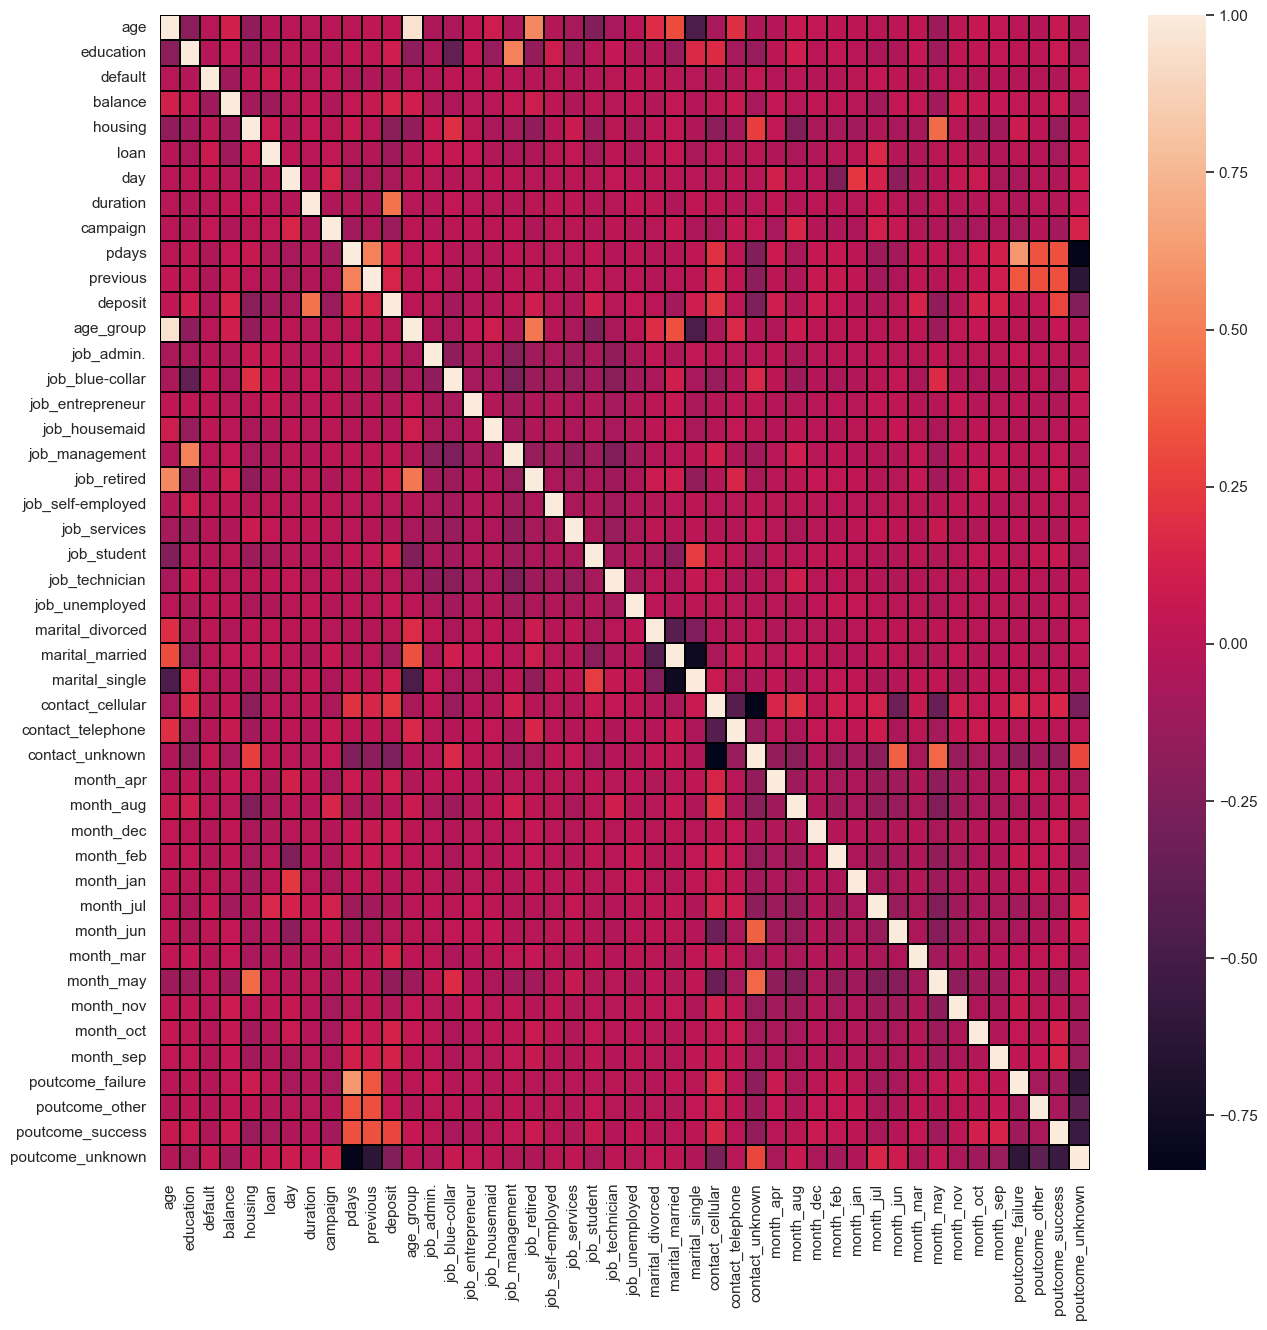

In [88]:
sns.set(rc={"figure.figsize":(15, 15)}) #width=3, #height=4
sns.heatmap(df.corr(),linecolor='black', linewidths=0.1)

In [89]:
display(df.corr())

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
age,1.000000,-0.191124,-0.009929,0.115164,-0.164196,-0.026357,0.000396,-0.006007,-0.001143,0.006107,...,0.009769,0.024785,-0.119656,0.026875,0.056998,0.036352,0.001994,-0.020942,0.060009,-0.031455
education,-0.191124,1.000000,-0.015692,0.043251,-0.094350,-0.052566,0.008989,-0.016869,-0.012280,0.024123,...,-0.036503,0.052196,-0.104157,0.028704,0.027617,0.030846,0.019845,0.015103,0.070489,-0.069069
default,-0.009929,-0.015692,1.000000,-0.110928,0.009551,0.074786,0.018724,-0.008162,0.033404,-0.037323,...,0.019626,-0.020028,-0.001761,0.000544,-0.023931,-0.016977,-0.025450,-0.017923,-0.041510,0.055032
balance,0.115164,0.043251,-0.110928,1.000000,-0.094919,-0.113089,-0.009987,0.025781,-0.042689,0.045155,...,0.039753,0.043832,-0.098073,0.081861,0.057041,0.047841,0.031040,0.028111,0.073358,-0.085456
housing,-0.164196,-0.094350,0.009551,-0.094919,1.000000,0.072252,-0.022644,0.038492,0.006257,0.064138,...,-0.073133,-0.075948,0.432605,-0.000219,-0.092026,-0.086893,0.085167,0.009830,-0.134477,0.024082
loan,-0.026357,-0.052566,0.074786,-0.113089,0.072252,1.000000,0.019136,0.001476,0.033889,-0.030788,...,-0.014897,-0.041105,0.002778,0.017720,-0.032357,-0.046196,0.007458,-0.019289,-0.082098,0.059235
day,0.000396,0.008989,0.018724,-0.009987,-0.022644,0.019136,1.000000,-0.016695,0.142169,-0.078757,...,-0.182032,-0.044303,-0.014580,0.056471,0.072179,-0.068744,-0.071175,-0.008806,-0.044366,0.085442
duration,-0.006007,-0.016869,-0.008162,0.025781,0.038492,0.001476,-0.016695,1.000000,-0.042576,-0.033053,...,-0.003061,-0.034640,0.007983,-0.015655,-0.012541,-0.012077,-0.039476,-0.009497,-0.025971,0.050571
campaign,-0.001143,-0.012280,0.033404,-0.042689,0.006257,0.033889,0.142169,-0.042576,1.000000,-0.105214,...,0.046763,-0.030574,-0.044348,-0.077307,-0.071519,-0.048672,-0.082282,-0.024854,-0.094260,0.134842
pdays,0.006107,0.024123,-0.037323,0.045155,0.064138,-0.030788,-0.078757,-0.033053,-0.105214,1.000000,...,-0.093551,0.024192,0.028678,-0.007350,0.079833,0.110907,0.608719,0.338049,0.326215,-0.824031


### Задания 5 и 6

In [90]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

### Задания 7 и 8

In [91]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [92]:
X_test.info()
round(y_test.mean(), 2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3335 entries, 3333 to 3818
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                3335 non-null   int64  
 1   education          3335 non-null   int32  
 2   default            3335 non-null   int64  
 3   balance            3335 non-null   float64
 4   housing            3335 non-null   int64  
 5   loan               3335 non-null   int64  
 6   day                3335 non-null   int64  
 7   duration           3335 non-null   int64  
 8   campaign           3335 non-null   int64  
 9   pdays              3335 non-null   int64  
 10  previous           3335 non-null   int64  
 11  age_group          3335 non-null   int64  
 12  job_admin.         3335 non-null   uint8  
 13  job_blue-collar    3335 non-null   uint8  
 14  job_entrepreneur   3335 non-null   uint8  
 15  job_housemaid      3335 non-null   uint8  
 16  job_management     33

0.46

### Задание 9

In [93]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)

a=list(selector.get_feature_names_out())

In [94]:
a

['balance',
 'housing',
 'loan',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

### Задание 10

In [95]:
X_train = X_train[a]

In [96]:
X_test = X_test[a]

In [97]:
mm_scaler = preprocessing.MinMaxScaler()
mm_scaler.fit(X_train)
X_train_scaled = mm_scaler.transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)
X_test_scaled[:, 0].mean().round(2)

0.47

In [98]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3335 entries, 3333 to 3818
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   balance           3335 non-null   float64
 1   housing           3335 non-null   int64  
 2   loan              3335 non-null   int64  
 3   duration          3335 non-null   int64  
 4   campaign          3335 non-null   int64  
 5   pdays             3335 non-null   int64  
 6   previous          3335 non-null   int64  
 7   contact_cellular  3335 non-null   uint8  
 8   contact_unknown   3335 non-null   uint8  
 9   month_mar         3335 non-null   uint8  
 10  month_may         3335 non-null   uint8  
 11  month_oct         3335 non-null   uint8  
 12  month_sep         3335 non-null   uint8  
 13  poutcome_success  3335 non-null   uint8  
 14  poutcome_unknown  3335 non-null   uint8  
dtypes: float64(1), int64(6), uint8(8)
memory usage: 234.5 KB


In [99]:
X_test_scaled

array([[0.36060209, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.41901178, 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.56479058, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.28435864, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.37614529, 0.        , 1.        , ..., 0.        , 0.        ,
        1.        ],
       [0.36878272, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ]])

In [100]:
X_test_scaled[:,0].mean().round(2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [101]:
# обучите логистическую регрессию и рассчитайте метрики качества

#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000, random_state=42, solver='sag')
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test_scaled, y_test)))
y_test_pred = log_reg.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.78


### Задания 2,3,4

In [111]:
# обучите решающие деревья, настройте максимальную глубину

dec_trees = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=6)

dec_trees.fit(X_train_scaled, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(dec_trees.score(X_test_scaled, y_test)))
y_test_pred = log_reg.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.78


### Задание 5

In [116]:
from sklearn.model_selection import GridSearchCV

param_grid = {
              'min_samples_split': [2, 5, 7, 10],
              'max_depth':[3,5,7]
              }
grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(
        random_state=42 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))
y_test_pred = grid_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 250 ms
Wall time: 2.1 s
accuracy на тестовом наборе: 0.79
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 10}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [123]:
# обучите на ваших данных случайный лес
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42, 
        n_estimators = 100,
        criterion = 'gini',
        min_samples_leaf = 5,
        max_depth = 10
)

#Обучаем модель
rf.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train_scaled)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test_scaled)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

Train: 0.84
Test: 0.82
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [127]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    loss='log_loss', #функция потерь
    learning_rate=0.05, #темп обучения
    n_estimators=300, #число деревьев
    max_depth=5, #максимальная глубина дерева
    random_state=42, #генератор случайных чисел
    min_samples_leaf=5
)
# Обучаем модель
gb.fit(X_train, y_train)
# Формируем предсказание для тестовой выборки
y_pred = gb.predict(X_test)
# Посмотрим на основные метрики классификации
print(classification_report(y_test, y_pred))

print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.precision_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.80      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335

f1_score на тестовом наборе: 0.82
f1_score на тестовом наборе: 0.80


### Задание 4

In [131]:
# объедините уже известные вам алгоритмы с помощью стекинга 
import optuna

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
  random_state=42

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

In [132]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-06-07 13:26:28,485] A new study created in memory with name: RandomForestClassifier
[I 2023-06-07 13:26:29,153] Trial 0 finished with value: 0.8671546488085967 and parameters: {'n_estimators': 103, 'max_depth': 23, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8671546488085967.
[I 2023-06-07 13:26:30,187] Trial 1 finished with value: 0.8442571785268415 and parameters: {'n_estimators': 196, 'max_depth': 30, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8671546488085967.
[I 2023-06-07 13:26:30,717] Trial 2 finished with value: 0.8532167395377889 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8671546488085967.
[I 2023-06-07 13:26:31,590] Trial 3 finished with value: 0.8881228455029772 and parameters: {'n_estimators': 135, 'max_depth': 29, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.8881228455029772.
[I 2023-06-07 13:26:32,588] Trial 4 finished with value: 0.888052681091251 and parameters: {'n_e

CPU times: total: 17.2 s
Wall time: 17.4 s


In [133]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 181, 'max_depth': 20, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.91


In [134]:
# обучите на ваших данных случайный лес
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42, 
        n_estimators = 181,
        criterion = 'gini',
        min_samples_leaf = 2,
        max_depth = 20
)

#Обучаем модель
rf.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train_scaled)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test_scaled)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

Train: 0.91
Test: 0.81
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1790
           1       0.79      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



In [136]:
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.79
f1_score на тестовом наборе: 0.81


### Задание 5

In [107]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [108]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna